In [36]:
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Activation,Embedding
from keras.layers import Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import decomposition
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from matplotlib import pyplot
from numpy import array

import scikitplot as skplt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
import time
from keras import metrics
from keras import optimizers
from keras import initializers
from keras.callbacks import ModelCheckpoint
import pprint
from keras.callbacks import Callback
from keras.models import load_model
from sklearn import metrics
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import Normalizer
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

## Read  Dataset

In [37]:
df = pd.read_csv('h_train_sm.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,45.0,1.0,1.521928,Aria
1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,29.0,1.0,...,0.0,0.0,4.0,0.0,1.0,3.0,40.0,0.0,0.000000,Aria
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,4.0,0.0,1.0,1.0,328.0,0.0,0.000000,Aria
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,3.0,0.0,3.0,1.0,60.0,0.0,0.000000,Aria


## Split Dataset Train & Validation

In [38]:

X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data
X.shape

(270000, 25)

In [39]:
from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)


In [40]:
y

array([ 0,  0,  0, ..., 26, 26, 26])

In [41]:
from keras.utils import np_utils
y = np_utils.to_categorical(y)

In [42]:
y

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [43]:
#Train test validation split - 60:20:20
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.2,
                                                    random_state=42)


In [44]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))

In [45]:
# reshape input to be [samples, time steps, features]
Y_train = np.reshape(Y_train, (Y_train.shape[0],  Y_train.shape[1]))
Y_val = np.reshape(Y_val, (Y_val.shape[0],  Y_val.shape[1]))

## Hyperparameters

In [46]:
model_FileName = "long_mc_bestWeightsLSTMStateless3L50.hdf5"
number_of_units=50
Batch_size = 10
randomInit = initializers.RandomUniform(seed=42)
lr=0.002
Epochs=30
dropout=0.2

In [47]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(model_FileName,monitor='val_acc',verbose=1,save_best_only=True,mode='max',save_weights_only=True)
nadam = optimizers.Nadam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, schedule_decay=0.004)

In [48]:
model = Sequential()
model.add(LSTM(number_of_units, return_sequences=True,kernel_initializer = randomInit, bias_initializer = randomInit,
               input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(dropout))
model.add(LSTM(int(number_of_units), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(int(number_of_units)))
model.add(Dropout(dropout))
model.add(Dense(Y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=nadam, metrics=['accuracy'])
print(model.summary())



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 50)             15200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 27)                1377      
Total para

In [49]:
#Time to train

start_time = time.time()




history=model.fit(X_train, Y_train, epochs=Epochs, batch_size=Batch_size, verbose=1, shuffle=False,
            validation_data = (X_val,Y_val),callbacks=[checkpoint,es])  

print("--- %s seconds ---" % (time.time() - start_time))






Train on 216000 samples, validate on 54000 samples
Epoch 1/30
216000/216000 [==============================] - 149s 689us/step - loss: 2.5593 - acc: 0.1999 - val_loss: 2.1839 - val_acc: 0.2854

Epoch 00001: val_acc improved from -inf to 0.28544, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 2/30
216000/216000 [==============================] - 186s 860us/step - loss: 2.1240 - acc: 0.3040 - val_loss: 1.7703 - val_acc: 0.3986

Epoch 00002: val_acc improved from 0.28544 to 0.39857, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 3/30
216000/216000 [==============================] - 176s 817us/step - loss: 1.8878 - acc: 0.3585 - val_loss: 1.5886 - val_acc: 0.4455

Epoch 00003: val_acc improved from 0.39857 to 0.44554, saving model to long_mc_bestWeightsLSTMStateless3L50.hdf5
Epoch 4/30
216000/216000 [==============================] - 165s 762us/step - loss: 1.7709 - acc: 0.3904 - val_loss: 1.5424 - val_acc: 0.4691

Epoch 00004: val_acc improved from 0.4455

In [50]:
model.save(model_FileName[:-3])  # creates a HDF5 file 'my_model.h5'


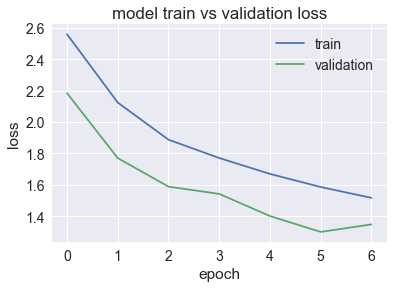

In [51]:



 

pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')




pyplot.show()

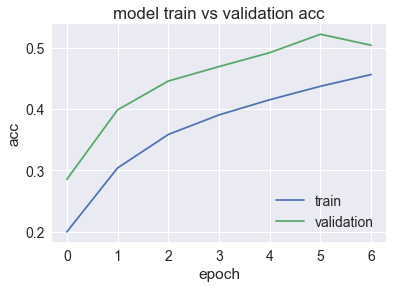

In [52]:

pyplot.plot(history.history['acc'])
pyplot.plot(history.history['val_acc'])
pyplot.title('model train vs validation acc')
pyplot.ylabel('acc')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='lower right')
pyplot.show()

## Test

In [53]:
df = pd.read_csv('h_test_sk.csv',header=None )
np.random.seed(42)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria
1,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,765,1,5.567481,Aria
2,0,0,0,1,0,0,1,0,29200,1,...,0,0,4,0,1,2,48,0,0.000000,Aria
3,1,0,0,0,0,0,0,0,0,0,...,0,0,4,0,0,0,0,0,0.000000,Aria
4,0,0,0,1,0,0,1,0,29,1,...,0,0,4,0,1,3,40,0,0.000000,Aria


In [54]:
## 
X =df[df.columns[0:-1]]
X=np.array(X)

y=df[df.columns[-1]]  

scaler = Normalizer().fit(X)
X = scaler.transform(X)
# summarize transformed data



from sklearn import preprocessing 
le = preprocessing.LabelEncoder()
y=le.fit_transform(y)



from keras.utils import np_utils
y = np_utils.to_categorical(y)


# reshape input to be [samples, time steps, features]
X_test = np.reshape(X, (X.shape[0], 1, X.shape[1]))



# reshape input to be [samples, time steps, features]
Y_test = np.reshape(y, (y.shape[0],  y.shape[1]))


In [55]:
Y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

## TEST DEĞERLENDİRME

In [56]:
loss,acc = model.evaluate(X_test,Y_test,batch_size=Batch_size)
print("Loss for testing = {} and Accuracy for testing = {}".format(loss,acc))
predicted = model.predict(X_test)

81000/81000 [==============================] - 19s 234us/step
Loss for testing = 1.3850835488708173 and Accuracy for testing = 0.491555558209434


In [57]:
(predicted.shape)

(81000, 27)

In [58]:
#predicted = model.predict(X_test)

In [59]:
(predicted.shape)

(81000, 27)

### grafik mırafik

In [60]:
def compute_metrics(predicted, Y_test):   
    Y_classes = [np.argmax(item) for item in Y_test]
    #print(Y_classes)
    predicted_classes = [np.argmax(item) for item in predicted]
    predictions = np.array(predicted_classes)
    Y_actual = np.array(Y_classes)
   
    y_actu = pd.Series(np.reshape(Y_actual,len(Y_actual)), name='Actual')
    y_pred = pd.Series(np.reshape(predictions, len(predictions)), name='Predicted')
    
    y_act = pd.Categorical(y_actu, categories=list(range(0,27)))
    y_pre = pd.Categorical(y_pred, categories=list(range(0,27)))
    
    #F1 score
    from sklearn.metrics import f1_score
    print("Average F1 score is {}".format(f1_score(Y_classes, predicted_classes, average='weighted', labels = list(range(0,27)))))
    
    df_confusion = pd.crosstab(y_act, y_pre, rownames =['Actual'],colnames=['Predicted'])
    print("Confusion matrix: \n", df_confusion)
    #pprint.pprint(df_confusion)
    
    predicted= np.array(predicted).tolist()
    Y_test = np.array(Y_test).tolist()

    n_classes = 27
    print("n_classes is: ", n_classes)
    Y_test= np.asarray(Y_test)
    predicted = np.asarray(predicted)
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], predicted[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    lw = 2
    # Compute macro-average ROC curve and ROC area
    #First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()
    return df_confusion

In [61]:
predicted

array([[9.9957770e-01, 7.8413530e-07, 1.3208283e-10, ..., 6.4966656e-08,
        2.0946178e-08, 3.4535103e-06],
       [9.9543059e-01, 1.2677898e-05, 1.2989355e-07, ..., 4.1945671e-07,
        1.1805718e-06, 1.5578586e-04],
       [1.6022022e-01, 1.3970248e-02, 3.4289880e-04, ..., 2.0649111e-02,
        5.5962899e-03, 2.2433843e-01],
       ...,
       [2.1334127e-01, 7.1076239e-03, 4.3889150e-04, ..., 1.1358834e-02,
        4.3120598e-03, 2.8885463e-01],
       [3.3326066e-01, 2.0865223e-04, 7.4784963e-05, ..., 5.8783847e-03,
        6.9585966e-04, 2.9318437e-01],
       [2.1335194e-01, 7.1051419e-03, 4.3885090e-04, ..., 1.1358490e-02,
        4.3122200e-03, 2.8887475e-01]], dtype=float32)

In [62]:
print(predicted.shape, Y_test.shape)

(81000, 27) (81000, 27)


Average F1 score is 0.48027911120014144
Confusion matrix: 
 Predicted    0     1     2     3     4   5    6    7     8     9   ...   17  \
Actual                                                             ...        
0          2317     0     0     0     0   0    0    0     0     0  ...  183   
1             1  2120   116     0    45   1    2   25   421    34  ...   18   
2            19     0  1582     0     0   0    0    0     0  1251  ...   88   
3            32     0    11  2741     0   3    0    0    81    50  ...    0   
4             4   302     5     0  1034  21   50  252   917     0  ...    0   
5            12   194    19     0   456  48   85  405  1449    15  ...    7   
6            10   199    22     0   474  31   79  284  1559    17  ...    6   
7             6   200    16     1   415  18   78  435  1511    28  ...    5   
8            13   183    24     0   480  74   59  286  1542    22  ...    7   
9            41     0   420     0     0   0    0    0     0  2170  ... 

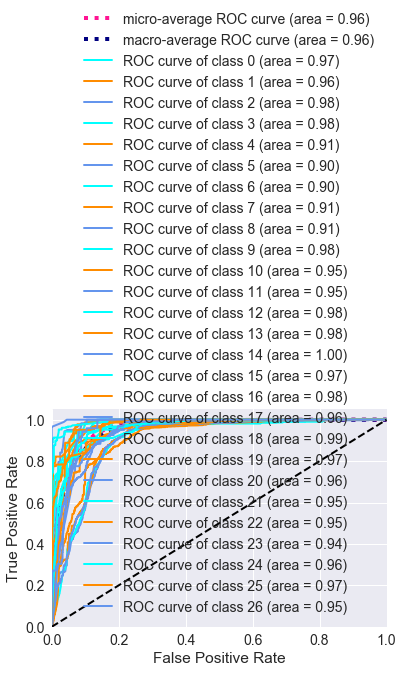

In [63]:
df=compute_metrics(predicted, Y_test)

In [64]:
matrix = metrics.confusion_matrix(Y_test.argmax(axis=1), predicted.argmax(axis=1))

In [65]:
cm=matrix

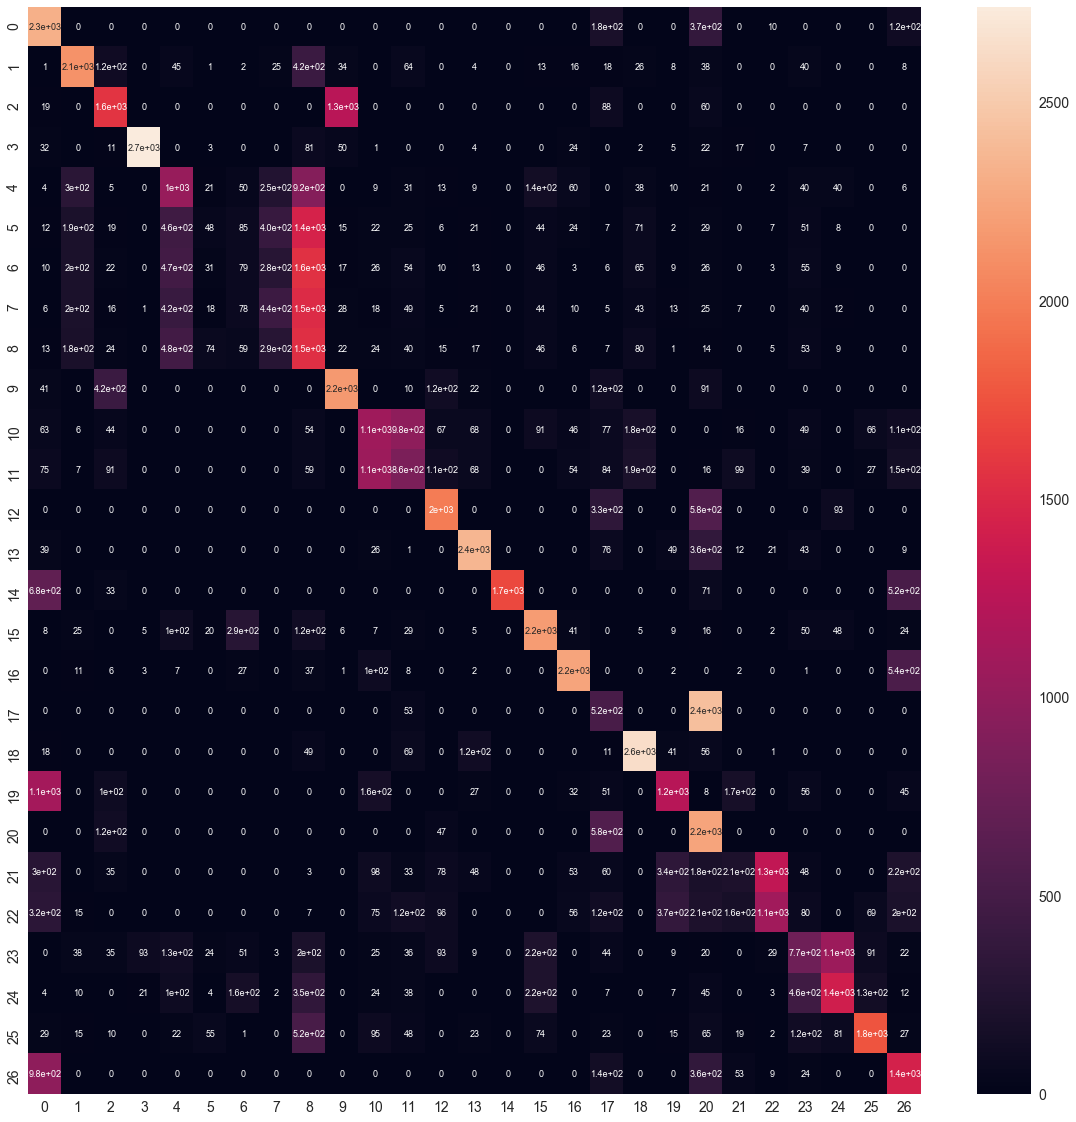

In [66]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt



df_cm = pd.DataFrame(matrix, range(27), range(27))
plt.figure(figsize=(20,20))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 9}) # font size

plt.show()

 ## blove part taken from https://www.python-course.eu/confusion_matrix.php

In [67]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

print("label precision recall fscore")
for label in range(27):
    pr=precision(label, cm)
    rec=recall(label, cm)
    f1=2*(pr*rec/(pr+rec))
    print(f"{label:5d} {pr:9.3f} {rec:6.3f} {f1:6.3f}")

label precision recall fscore
    0     0.381  0.772  0.510
    1     0.638  0.707  0.670
    2     0.587  0.527  0.555
    3     0.957  0.914  0.935
    4     0.317  0.345  0.330
    5     0.161  0.016  0.029
    6     0.090  0.026  0.041
    7     0.257  0.145  0.185
    8     0.174  0.514  0.260
    9     0.604  0.723  0.658
   10     0.380  0.363  0.371
   11     0.338  0.287  0.311
   12     0.749  0.663  0.703
   13     0.831  0.787  0.809
   14     1.000  0.564  0.722
   15     0.700  0.730  0.715
   16     0.841  0.748  0.792
   17     0.202  0.173  0.186
   18     0.791  0.879  0.833
   19     0.583  0.413  0.483
   20     0.305  0.749  0.433
   21     0.278  0.071  0.113
   22     0.441  0.366  0.400
   23     0.380  0.257  0.307
   24     0.508  0.469  0.488
   25     0.821  0.586  0.684
   26     0.417  0.478  0.445


In [68]:
def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 
accuracy(cm)

0.4915555555555556

## MODEL SAVING RELOADING

In [69]:
from keras.models import load_model
model.save(model_FileName)  # creates a HDF5 file 'my_model.h5'



In [70]:

# returns a compiled model
# identical to the previous one
model = load_model('54.h5')

OSError: Unable to open file (unable to open file: name = '54.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
len(predicted)

In [ ]:
float_formatter = "{:.2f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

In [ ]:


ths =open( "y_and_p_compare.csv", "w")


counter=-1
for i in range (len(predicted)):
    float_formatter = "{:.2f}".format
    print(Y_test[i],predicted[i])
    
    y= str(counter)+"-"+str(i)+"-            "+str(Y_test[i])
    y=y.replace("\n","")
    y=y+"\n"
    p=  str(counter)+"-"+str(i)+"-            "+str(predicted[i])
    p=p.replace("\n","")
    p=p+"\n"
    ths.write(y)
    ths.write(p)
    ths.write("\n")
    
    if i%50==0:
        counter=counter+1
        print(counter)
ths.close()        